# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [1]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [17]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [8]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.07 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018716299999999464 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [9]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

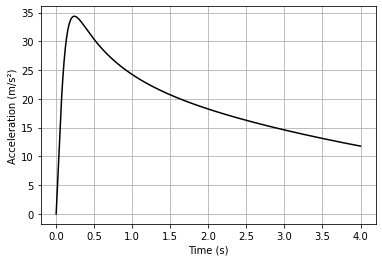

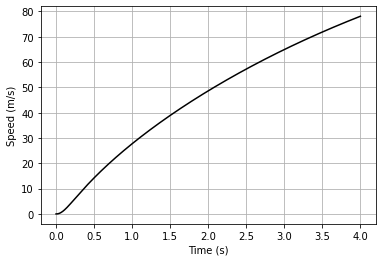

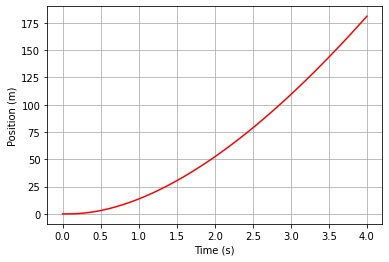

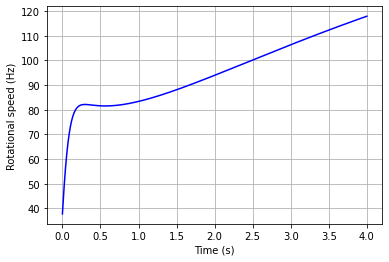

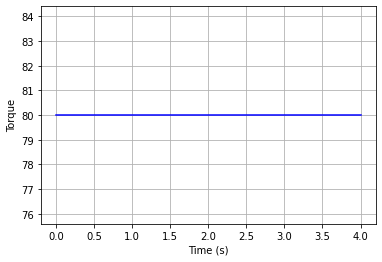

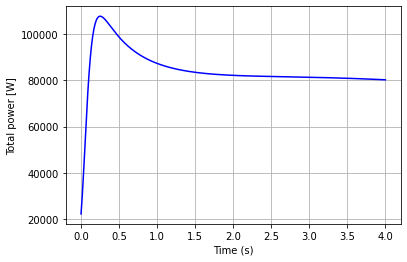

In [10]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [11]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [12]:
api.optimization_viewer(CONFIGURATION_FILE)

In [23]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018143800000075316 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.020959800000014184 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0220688000000564 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02203580000002603 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01967390000004343 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02061679999997068 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.020366100000046572 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01819850000003953 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02073299

Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.0348137000000861 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.030421499999988555 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.03202010000006794 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.025233699999944292 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.027145100000097955 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.022052000000030603 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.022960599999919395 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.02318359999992481 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.025054100000033

Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.020793900000057874 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.02048730000001342 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.019257600000059938 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.01845329999991918 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.0228865000000269 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.020764699999972436 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.01794239999992442 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.020511800000008407 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.0202965

Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018861499999957232 seconds.
Simulation interval    : 0.0 - 5.838976601982371 seconds.
Elapsed simulation time: 0.02044660000001386 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.021420400000010886 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.020461199999999735 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.020453099999940605 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018210399999929905 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.020380300000056195 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.02033670000002985 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.0207857000000

Elapsed simulation time: 0.02017000000000735 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.019349900000065645 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.022676799999999275 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.02063050000003841 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.018995900000049915 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.020592799999917588 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.0208445999999185 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.020459200000004785 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.020125099999972917 seconds.
Simulation interval    : 0.0 - 4.701998204266

Simulation interval    : 0.0 - 3.2943866784058233 seconds.
Elapsed simulation time: 0.020413700000062818 seconds.
Simulation interval    : 0.0 - 3.2943866784058233 seconds.
Elapsed simulation time: 0.022865900000056172 seconds.
Simulation interval    : 0.0 - 3.2943866784058233 seconds.
Elapsed simulation time: 0.02016029999992952 seconds.
Simulation interval    : 0.0 - 3.2943866784058233 seconds.
Elapsed simulation time: 0.04466000000002168 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.023092099999985294 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.023871800000051735 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.019461800000044605 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.02789020000000164 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.02078

Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.020634599999993952 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.02035820000003241 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.019174400000110836 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.02029210000000603 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.0241280000000188 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.02467680000006567 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.026070400000094196 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.02072109999994609 seconds.
Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.02352849

Elapsed simulation time: 0.020784100000014405 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.02111220000006142 seconds.
Simulation interval    : 0.0 - 2.4781633559784724 seconds.
Elapsed simulation time: 0.024873500000012427 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.020382199999971817 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.020359799999937422 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.01917959999991581 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.020510100000024067 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.021377199999960794 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.02023410000003878 seconds.
Simulation interval    : 0.0 - 2.4781623559

Simulation interval    : 0.0 - 2.8052898748357604 seconds.
Elapsed simulation time: 0.01877310000008947 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.020635200000015175 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.021226800000022195 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.01862970000001951 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018583199999966382 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.019602499999905376 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.02127630000006775 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.01997679999999491 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.021134

Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.01820769999994809 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.019552399999952286 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.021167300000001887 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.02118319999999585 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.020733500000005733 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.020623800000066694 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.020348799999965195 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.01814280000007784 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.02060

Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.02052250000008371 seconds.
Simulation interval    : 0.0 - 2.8474241140770866 seconds.
Elapsed simulation time: 0.020720299999993586 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.021654000000012275 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.02008699999998953 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.0203963000000158 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.018974299999968025 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.02066869999998744 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.02080060000002959 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.02012260

Simulation interval    : 0.0 - 2.847153652096447 seconds.
Elapsed simulation time: 0.018852499999979955 seconds.
Simulation interval    : 0.0 - 2.7672597455584436 seconds.
Elapsed simulation time: 0.018794999999954598 seconds.
Simulation interval    : 0.0 - 2.8374154381459644 seconds.
Elapsed simulation time: 0.020753600000034567 seconds.
Simulation interval    : 0.0 - 2.8457913021602272 seconds.
Elapsed simulation time: 0.021001899999987472 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.02166910000005373 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.021257499999933316 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.020399900000029447 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.022233899999946516 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.021512800

Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.02573440000003302 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.0205534000000398 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.021186299999953917 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.020453400000064903 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.020327699999938886 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018594599999914863 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.01929569999992964 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.02021819999993113 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.0206498999999666

Simulation interval    : 0.0 - 2.9290514593204184 seconds.
Elapsed simulation time: 0.01949440000009872 seconds.
Simulation interval    : 0.0 - 3.2355985010442936 seconds.
Elapsed simulation time: 0.01809009999999489 seconds.
Simulation interval    : 0.0 - 2.959706163492806 seconds.
Elapsed simulation time: 0.020330799999896954 seconds.
Simulation interval    : 0.0 - 2.9347995683651504 seconds.
Elapsed simulation time: 0.018944799999985662 seconds.
Simulation interval    : 0.0 - 2.930057437841734 seconds.
Elapsed simulation time: 0.01943549999998595 seconds.
Simulation interval    : 0.0 - 2.929231264461246 seconds.
Elapsed simulation time: 0.01870280000002822 seconds.
Simulation interval    : 0.0 - 2.929087513320365 seconds.
Elapsed simulation time: 0.018333100000063496 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.02040260000001126 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.0186901999999

Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.019575900000063484 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.02913869999997587 seconds.
Simulation interval    : 0.0 - 2.9347445499542655 seconds.
Elapsed simulation time: 0.046696300000007795 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.02104430000008506 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.023540499999967324 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.021572900000023765 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.029534600000033606 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018831200000022363 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 2.9389864191261963 seconds.
Elapsed simulation time: 0.02454709999994975 seconds.
Simulation interval    : 0.0 - 2.9389864191261963 seconds.
Elapsed simulation time: 0.019010600000001432 seconds.
Simulation interval    : 0.0 - 3.0351957836563423 seconds.
Elapsed simulation time: 0.021995999999944615 seconds.
Simulation interval    : 0.0 - 2.948607355579211 seconds.
Elapsed simulation time: 0.019180299999902672 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.024089799999956085 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.01849790000005669 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.017900000000054206 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.019060899999999492 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.0180758999

Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.019629499999950895 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01884749999999258 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01801019999993514 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.018710699999928693 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01857940000002145 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.018400100000008024 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.018330900000023576 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.0182355000000598 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.0182891

Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01928290000000743 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.018680399999993824 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01895219999994424 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.018571800000017902 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.018220799999994597 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.019744500000001608 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.0195634000000382 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01808199999993576 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.0189414999999826

Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018203200000016295 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.01873960000000352 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.020157899999958317 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.01874540000005709 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.019339699999932236 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.0178169999999227 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018736800000056064 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018213000000059765 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018299200000001292 secon

Simulation interval    : 0.0 - 2.9996570379895036 seconds.
Elapsed simulation time: 0.01930979999997362 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018429399999945417 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.01917609999998149 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.019336199999997916 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.01845570000000407 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018148800000062693 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018560800000045674 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018340699999953358 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.01877

Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.018019800000047326 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01914739999995163 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.018077599999969607 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.019464999999968313 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.018454199999951015 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01810350000005201 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.018680500000073152 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01813589999994747 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01997970000002

Simulation interval    : 0.0 - 2.9996059822034598 seconds.
Elapsed simulation time: 0.01841720000004443 seconds.
Simulation interval    : 0.0 - 2.9996059822034598 seconds.
Elapsed simulation time: 0.018482300000073337 seconds.
Simulation interval    : 0.0 - 2.9996059822034598 seconds.
Elapsed simulation time: 0.018228499999963788 seconds.
Simulation interval    : 0.0 - 2.928065734423117 seconds.
Elapsed simulation time: 0.02009930000008353 seconds.
Simulation interval    : 0.0 - 2.987254471369634 seconds.
Elapsed simulation time: 0.018924500000025546 seconds.
Simulation interval    : 0.0 - 2.9971015003849617 seconds.
Elapsed simulation time: 0.018531199999983983 seconds.
Simulation interval    : 0.0 - 2.9990553344431183 seconds.
Elapsed simulation time: 0.019423299999971277 seconds.
Simulation interval    : 0.0 - 2.999494814661282 seconds.
Elapsed simulation time: 0.017955400000005284 seconds.
Simulation interval    : 0.0 - 2.9995833991061844 seconds.
Elapsed simulation time: 0.0191099

Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.019422999999960666 seconds.
Simulation interval    : 0.0 - 2.842917937353449 seconds.
Elapsed simulation time: 0.019001199999934215 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.020174699999984114 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01875669999992624 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01899470000000747 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01805500000000393 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.018122400000038397 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01918809999995119 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.018610899999998

Simulation interval    : 0.0 - 2.886441309946823 seconds.
Elapsed simulation time: 0.01936000000000604 seconds.
Simulation interval    : 0.0 - 2.886441309946823 seconds.
Elapsed simulation time: 0.01787560000002486 seconds.
Simulation interval    : 0.0 - 3.0848690756626187 seconds.
Elapsed simulation time: 0.019565699999930075 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.020010799999909068 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018924400000059904 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018628599999942708 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018403499999976702 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018951399999991736 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018368

Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.01832810000007612 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.0186678000000029 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.01917279999997845 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.01807050000002164 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.017963399999985086 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.019347400000015114 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.018606800000043222 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.018290200000024015 seconds.
Simulation interval    : 0.0 - 2.9096919500303975 seconds.
Elapsed simulation time: 0.0191763

Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.01847259999999551 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018686199999933706 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.023609200000009878 seconds.
Simulation interval    : 0.0 - 2.914279857060436 seconds.
Elapsed simulation time: 0.018504500000062762 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.019687099999941893 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.017835699999977805 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.01804390000006606 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.0195578000000296 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.0187281

Simulation interval    : 0.0 - 2.914690353268658 seconds.
Elapsed simulation time: 0.02047519999996439 seconds.
Simulation interval    : 0.0 - 2.914690353268658 seconds.
Elapsed simulation time: 0.020107600000073944 seconds.
Simulation interval    : 0.0 - 2.914690353268658 seconds.
Elapsed simulation time: 0.018706000000065615 seconds.
Simulation interval    : 0.0 - 2.914690353268658 seconds.
Elapsed simulation time: 0.018835400000057234 seconds.
Simulation interval    : 0.0 - 2.914690353268658 seconds.
Elapsed simulation time: 0.03450840000004973 seconds.
Simulation interval    : 0.0 - 3.1506266854117237 seconds.
Elapsed simulation time: 0.01879719999999452 seconds.
Simulation interval    : 0.0 - 2.9382839864829644 seconds.
Elapsed simulation time: 0.018491499999981897 seconds.
Simulation interval    : 0.0 - 2.917049716590088 seconds.
Elapsed simulation time: 0.021039299999983996 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.019799499999

Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.01948779999997896 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.01859079999996993 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018562599999995655 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.01745240000002468 seconds.
Simulation interval    : 0.0 - 2.914960564967148 seconds.
Elapsed simulation time: 0.019728699999973287 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.020306900000036876 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.019520999999940614 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018537400000013804 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018722

Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.01854209999999057 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018785899999897993 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018081499999993866 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018674400000008973 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018636399999991227 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018362899999942783 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.0194182999999839 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.018104399999970155 seconds.
Simulation interval    : 0.0 - 2.9149620877835245 seconds.
Elapsed simulation time: 0.01941

Simulation interval    : 0.0 - 3.135082676049509 seconds.
Elapsed simulation time: 0.02063989999999194 seconds.
Simulation interval    : 0.0 - 2.9400946216368182 seconds.
Elapsed simulation time: 0.018583899999953246 seconds.
Simulation interval    : 0.0 - 2.918525733189809 seconds.
Elapsed simulation time: 0.01821719999998095 seconds.
Simulation interval    : 0.0 - 2.9154595560215744 seconds.
Elapsed simulation time: 0.019301199999972596 seconds.
Simulation interval    : 0.0 - 2.9150319664500084 seconds.
Elapsed simulation time: 0.01852519999999913 seconds.
Simulation interval    : 0.0 - 2.9149723329553336 seconds.
Elapsed simulation time: 0.019470100000035018 seconds.
Simulation interval    : 0.0 - 2.9149640179674616 seconds.
Elapsed simulation time: 0.018477599999982885 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.018261600000073486 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.0189427

Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.01880269999992379 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018705699999941316 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018871799999942596 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.019230500000048778 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018596100000081606 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.019804800000088107 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.017994900000076086 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018541600000048675 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.018912699999987126 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01874150000003283 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.018458399999985886 seconds.
Simulation interval    : 0.0 - 2.9149639575572714 seconds.
Elapsed simulation time: 0.017975299999989147 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.023647199999913937 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.018150399999967703 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.020581899999911002 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.021605600000043523 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.032

Simulation interval    : 0.0 - 2.914963644506501 seconds.
Elapsed simulation time: 0.018436700000052042 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.01952569999991738 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018500700000004144 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018502199999943514 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.01815509999994447 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018824300000005678 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018720700000017132 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018413699999996425 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.0187839999999

Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.02133969999999863 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.019523800000001756 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.020995100000050115 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.01883009999994556 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.02057609999997112 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.018872600000008788 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.019643800000039846 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.022322799999983545 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.02886

Simulation interval    : 0.0 - 2.8742300780617875 seconds.
Elapsed simulation time: 0.02661399999999503 seconds.
Simulation interval    : 0.0 - 2.8742300780617875 seconds.
Elapsed simulation time: 0.05041319999997995 seconds.
Simulation interval    : 0.0 - 3.373867904247917 seconds.
Elapsed simulation time: 0.034083500000065214 seconds.
Simulation interval    : 0.0 - 2.96106711118885 seconds.
Elapsed simulation time: 0.03185089999999491 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.019741999999951076 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.019285599999989245 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.028191899999910675 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.037524399999938396 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.02174420

Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018189399999982925 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018432899999993424 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018806100000006154 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018231399999990572 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.01843430000008084 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018486300000063238 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.018096599999921636 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.0174438999999893 seconds.
Simulation interval    : 0.0 - 2.990850322899187 seconds.
Elapsed simulation time: 0.01886780000006

Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018151500000044507 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.019068899999979294 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.01804540000000543 seconds.
Simulation interval    : 0.0 - 2.9960676580892813 seconds.
Elapsed simulation time: 0.018039300000054936 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.01865650000002006 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018340700000067045 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.0181248000000096 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.0425946999999951 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.0431007000000818

Simulation interval    : 0.0 - 2.996553048591453 seconds.
Elapsed simulation time: 0.02325529999995979 seconds.
Simulation interval    : 0.0 - 2.996553048591453 seconds.
Elapsed simulation time: 0.025407799999925373 seconds.
Simulation interval    : 0.0 - 2.996553048591453 seconds.
Elapsed simulation time: 0.020942500000046493 seconds.
Simulation interval    : 0.0 - 2.996553048591453 seconds.
Elapsed simulation time: 0.019508100000052764 seconds.
Simulation interval    : 0.0 - 3.2005601180431413 seconds.
Elapsed simulation time: 0.017921099999966827 seconds.
Simulation interval    : 0.0 - 3.0169537555366217 seconds.
Elapsed simulation time: 0.019081300000038937 seconds.
Simulation interval    : 0.0 - 2.99859311928597 seconds.
Elapsed simulation time: 0.01855450000005021 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018225000000029468 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.0186029999

Simulation interval    : 0.0 - 2.9973350065688007 seconds.
Elapsed simulation time: 0.01959790000000794 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.02049490000001697 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.020885099999986778 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.020334300000058647 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.017822700000010627 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.01788299999998344 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.018376699999976154 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.020421600000076978 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.02051

Simulation interval    : 0.0 - 2.997460956546995 seconds.
Elapsed simulation time: 0.021366499999999178 seconds.
Simulation interval    : 0.0 - 2.997460956546995 seconds.
Elapsed simulation time: 0.02075379999996585 seconds.
Simulation interval    : 0.0 - 2.997460956546995 seconds.
Elapsed simulation time: 0.0212755999999672 seconds.
Simulation interval    : 0.0 - 2.997460956546995 seconds.
Elapsed simulation time: 0.022350500000015927 seconds.
Simulation interval    : 0.0 - 3.2615061836027284 seconds.
Elapsed simulation time: 0.01840140000001611 seconds.
Simulation interval    : 0.0 - 3.0351836567489223 seconds.
Elapsed simulation time: 0.020540699999969547 seconds.
Simulation interval    : 0.0 - 3.0031038284329408 seconds.
Elapsed simulation time: 0.021012700000028417 seconds.
Simulation interval    : 0.0 - 2.998318839827878 seconds.
Elapsed simulation time: 0.021514700000011544 seconds.
Simulation interval    : 0.0 - 2.9975949917085916 seconds.
Elapsed simulation time: 0.02068859999

Simulation interval    : 0.0 - 2.9987847564202714 seconds.
Elapsed simulation time: 0.017901900000083515 seconds.
Simulation interval    : 0.0 - 2.9977707372268902 seconds.
Elapsed simulation time: 0.018235800000070412 seconds.
Simulation interval    : 0.0 - 2.99754861708171 seconds.
Elapsed simulation time: 0.020485100000087186 seconds.
Simulation interval    : 0.0 - 2.9974998734359133 seconds.
Elapsed simulation time: 0.018423700000084864 seconds.
Simulation interval    : 0.0 - 2.9974891725222603 seconds.
Elapsed simulation time: 0.020555800000011004 seconds.
Simulation interval    : 0.0 - 2.997486823151881 seconds.
Elapsed simulation time: 0.02062439999997423 seconds.
Simulation interval    : 0.0 - 2.9974863076031864 seconds.
Elapsed simulation time: 0.019682700000089426 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.02056619999996201 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.0204098

Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018983999999932166 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018697999999972126 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018906900000047244 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.01903370000002269 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018237599999906706 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.01872809999997571 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.020086100000071383 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018192999999996573 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.0179766999999

Simulation interval    : 0.0 - 2.9815374001408634 seconds.
Elapsed simulation time: 0.018092700000011064 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.017780300000026728 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01864499999999225 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.018880000000081054 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01830250000000433 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.018117800000027273 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.017954099999997197 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01825810000002548 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01895

Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018174600000065766 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.020869800000014038 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.021255900000028305 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.01861389999999119 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.01811689999999544 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018539400000008754 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018560900000011316 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018477599999982885 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 2.975054593702758 seconds.
Elapsed simulation time: 0.018454300000030344 seconds.
Simulation interval    : 0.0 - 2.973538912776459 seconds.
Elapsed simulation time: 0.0183587000000216 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.018585400000006302 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.01851970000006986 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.017997799999989184 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.018307499999991705 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.01796460000002753 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.018893700000035096 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.01803000

Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.01795449999997345 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018254899999988083 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.020282399999928202 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.019768900000030953 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018358100000000377 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018806700000027377 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.01806530000010298 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.017694099999971513 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.018280199999935576 seconds.
Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.01825830000007045 seconds.
Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.018189300000017283 seconds.
Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.01816329999996924 seconds.
Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.01987450000001445 seconds.
Simulation interval    : 0.0 - 2.9734068734848385 seconds.
Elapsed simulation time: 0.018182400000000598 seconds.
Simulation interval    : 0.0 - 3.1170727494128854 seconds.
Elapsed simulation time: 0.018392800000015086 seconds.
Simulation interval    : 0.0 - 2.988786500706232 seconds.
Elapsed simulation time: 0.0179140999999845 seconds.
Simulation interval    : 0.0 - 2.975078918571877 seconds.
Elapsed simulation time: 0.018900799

Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.019111500000008164 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.018413800000075753 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01808410000001004 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.019317300000011528 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.017970899999909307 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01830090000009932 seconds.
Simulation interval    : 0.0 - 3.0677482958042352 seconds.
Elapsed simulation time: 0.018448499999976775 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01809179999997923 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.0185217999999

Simulation interval    : 0.0 - 3.176547460845016 seconds.
Elapsed simulation time: 0.01820220000001882 seconds.
Simulation interval    : 0.0 - 3.176547460845016 seconds.
Elapsed simulation time: 0.018341599999985192 seconds.
Simulation interval    : 0.0 - 3.176547460845016 seconds.
Elapsed simulation time: 0.018525399999930414 seconds.
Simulation interval    : 0.0 - 3.4571118021557488 seconds.
Elapsed simulation time: 0.01811510000004546 seconds.
Simulation interval    : 0.0 - 3.204603894976089 seconds.
Elapsed simulation time: 0.01818320000006679 seconds.
Simulation interval    : 0.0 - 3.179353104258123 seconds.
Elapsed simulation time: 0.021288199999958124 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01865250000003016 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01856129999998757 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.018001599999

Simulation interval    : 0.0 - 3.1779794207162566 seconds.
Elapsed simulation time: 0.0182683000000452 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018460200000049554 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.017978999999968437 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.01796009999998205 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.017847300000084942 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018150199999922734 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018019299999991745 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.017997200000081648 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.0183025000000

Simulation interval    : 0.0 - 3.178269868927381 seconds.
Elapsed simulation time: 0.0178869000000077 seconds.
Simulation interval    : 0.0 - 3.178269868927381 seconds.
Elapsed simulation time: 0.018495700000016768 seconds.
Simulation interval    : 0.0 - 3.178269868927381 seconds.
Elapsed simulation time: 0.018320600000038212 seconds.
Simulation interval    : 0.0 - 2.8385879459443086 seconds.
Elapsed simulation time: 0.02139769999996588 seconds.
Simulation interval    : 0.0 - 3.1443016766290732 seconds.
Elapsed simulation time: 0.018493400000011206 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.01818249999996624 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.01805380000007517 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.018313300000045274 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.027289799999948627 sec

Elapsed simulation time: 0.018437799999901472 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.02526510000006965 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.01865459999999075 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.02144009999994978 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.018206099999929393 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.018352400000026137 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.019042399999989357 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.01892910000003667 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.0179388999999901 seconds.
Simulation interval    : 0.0 - 2.86368169306902

Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.018256800000017392 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.018274799999971947 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.018770200000062687 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.018200399999955152 seconds.
Simulation interval    : 0.0 - 2.4500878854619588 seconds.
Elapsed simulation time: 0.018564400000059322 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.017825900000048023 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.018214400000033493 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.01839159999997264 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.01858440000

Simulation interval    : 0.0 - 2.763568373946373 seconds.
Elapsed simulation time: 0.018212800000014795 seconds.
Simulation interval    : 0.0 - 2.7259138835152648 seconds.
Elapsed simulation time: 0.018701700000065102 seconds.
Simulation interval    : 0.0 - 2.707608715035301 seconds.
Elapsed simulation time: 0.01891960000000381 seconds.
Simulation interval    : 0.0 - 2.698483543982032 seconds.
Elapsed simulation time: 0.01834940000003371 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.018414500000062617 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.020269499999926666 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.02088210000010804 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.019075199999974757 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.0183167000000

Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.024059299999976247 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.01918280000006689 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.018990100000110033 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.019598900000005415 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.027348400000050788 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.021366499999999178 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.021250399999985348 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.02708350000000337 seconds.
Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.0221

Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01822519999996075 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.018183399999998073 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.017961800000080075 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01797939999994469 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01801690000002054 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.017937800000026982 seconds.
Simulation interval    : 0.0 - 2.6850477144234497 seconds.
Elapsed simulation time: 0.018089099999997416 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.018562900000006266 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01830

Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.01852809999991223 seconds.
Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.018367000000012013 seconds.
Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.01821979999999712 seconds.
Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.018103100000075756 seconds.
Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.019543500000054337 seconds.
Simulation interval    : 0.0 - 2.7214494791026476 seconds.
Elapsed simulation time: 0.021262100000058126 seconds.
Simulation interval    : 0.0 - 3.1155113345259227 seconds.
Elapsed simulation time: 0.020260200000052464 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.01817110000001776 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.01878

Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01775479999992058 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01816740000003847 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01827220000006946 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.018644800000060968 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01847680000003038 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.018101999999998952 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01859649999994417 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01813389999995252 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.017880300000001625 seconds

Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018440499999996973 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.01969659999997475 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.023088400000006004 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.01863109999999324 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.01924840000003769 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.01952449999998862 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.02181319999999687 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018382500000029722 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.0182160000000521

Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.018154399999957604 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.0182371000000785 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.018497099999990496 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.01974080000002232 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.01789859999996679 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.0180440000000317 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.01798150000001897 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.018480999999951564 seconds.
Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.018419200

Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018194900000025882 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.01823429999990367 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018344500000011976 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.020542599999998856 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.01819609999995464 seconds.
Simulation interval    : 0.0 - 2.7389781836579865 seconds.
Elapsed simulation time: 0.018433500000014647 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.01818130000003748 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018721400000003996 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.01863

Simulation interval    : 0.0 - 2.8563047767682974 seconds.
Elapsed simulation time: 0.017846000000076856 seconds.
Simulation interval    : 0.0 - 2.8563047767682974 seconds.
Elapsed simulation time: 0.018432999999959065 seconds.
Simulation interval    : 0.0 - 3.2806920965542443 seconds.
Elapsed simulation time: 0.017789900000025227 seconds.
Simulation interval    : 0.0 - 2.8987435087468922 seconds.
Elapsed simulation time: 0.018567699999948672 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.01863709999997809 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.018283999999994194 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.022233199999959652 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.01808779999998933 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.0181

Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018782900000019254 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.019092300000011164 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.01847850000001472 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.022997499999974025 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018929899999989175 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018998200000055476 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018767799999977797 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.01918790000001991 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.0180

Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018778799999950024 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.01822140000001582 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018086200000084318 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018255600000088634 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018220799999994597 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018199600000002647 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.018125199999985853 seconds.
Simulation interval    : 0.0 - 3.249087947670015 seconds.
Elapsed simulation time: 0.018217100000015307 seconds.
Simulation interval    : 0.0 - 2.9171869255333744 seconds.
Elapsed simulation time: 0.0183

Simulation interval    : 0.0 - 2.942011667875457 seconds.
Elapsed simulation time: 0.018389100000035796 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.019375999999965643 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01858900000001995 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01809390000005351 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01910880000002635 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.018456700000001547 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01785240000003796 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.018121599999972204 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.018887699999936

Simulation interval    : 0.0 - 3.11348629644183 seconds.
Elapsed simulation time: 0.022050199999966935 seconds.
Simulation interval    : 0.0 - 2.9724209231702607 seconds.
Elapsed simulation time: 0.018167100000027858 seconds.
Simulation interval    : 0.0 - 2.9514748201749077 seconds.
Elapsed simulation time: 0.01820020000002387 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.017828199999939898 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.021698800000081064 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.018161899999995512 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.018069400000058522 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.018055699999990793 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.01854

Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018678899999940768 seconds.
Simulation interval    : 0.0 - 2.948158496942752 seconds.
Elapsed simulation time: 0.01954760000000988 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.019790299999954186 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.021153799999979128 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018662899999981164 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.01959020000003875 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.03910269999994398 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.029128700000001118 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.02870669999992

Simulation interval    : 0.0 - 3.0447473412372386 seconds.
Elapsed simulation time: 0.01928490000000238 seconds.
Simulation interval    : 0.0 - 3.0230909498360585 seconds.
Elapsed simulation time: 0.01797369999997045 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018028399999934663 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018071700000064084 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018243900000015856 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018195699999978387 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.019009299999993345 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018320399999993242 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.020962499999995998 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.018383300000095915 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.02100570000004609 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.01959959999999228 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.02172700000005534 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.022733200000061515 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.02090120000002571 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.019842599999947197 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.025285

Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018365000000017062 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018415099999970153 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.019148299999983465 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.01869350000004033 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018184300000029907 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018249900000000707 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.01822730000003503 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018324499999948785 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.0179738000000

Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018655800000033196 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.021761999999966974 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.02045270000007804 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018228000000021893 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.01945079999995869 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018637899999930596 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.019865399999957845 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018740699999966637 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.0181364000000

Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.018510399999968286 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01873640000007981 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01787390000004052 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01849809999998797 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.018450099999995473 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01829499999996642 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.018255199999998695 seconds.
Simulation interval    : 0.0 - 3.042667987044903 seconds.
Elapsed simulation time: 0.019461599999999635 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.017846999999960

Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.018652899999892725 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.02097419999995509 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020395499999949607 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020850899999913963 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020554199999992306 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020868800000016563 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020470799999998235 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.020216300000015508 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018413799999962066 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018211000000064814 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018214400000033493 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018362300000035248 seconds.
Simulation interval    : 0.0 - 3.0473776054581285 seconds.
Elapsed simulation time: 0.02070170000001781 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018345999999951346 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.01814240000010159 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.01861430000008113 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.0184742999999

Elapsed simulation time: 0.01997340000002623 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.018958499999939704 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.01821109999991677 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.019933700000024146 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.019243100000039703 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.018545000000017353 seconds.
Simulation interval    : 0.0 - 3.1231212351892927 seconds.
Elapsed simulation time: 0.020814699999959885 seconds.
Simulation interval    : 0.0 - 3.055001053709349 seconds.
Elapsed simulation time: 0.019754300000045077 seconds.
Simulation interval    : 0.0 - 3.048314640298617 seconds.
Elapsed simulation time: 0.018433400000049005 seconds.
Simulation interval    : 0.0 - 3.0475

Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.021262499999920692 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018844500000000153 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018262899999967885 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018334299999992254 seconds.
Simulation interval    : 0.0 - 3.0476486428445266 seconds.
Elapsed simulation time: 0.0188533999998981 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018689799999947354 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.01898740000001453 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018514099999947575 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.01844

Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018744500000025255 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018357899999955407 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018066899999894304 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.01835849999997663 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018742800000040916 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018075500000009015 seconds.
Simulation interval    : 0.0 - 3.0629948420917765 seconds.
Elapsed simulation time: 0.018443400000023757 seconds.
Simulation interval    : 0.0 - 3.0547523616530645 seconds.
Elapsed simulation time: 0.018682199999943805 seconds.
Simulation interval    : 0.0 - 3.0537186616387726 seconds.
Elapsed simulation time: 0.019882900

Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.019469299999968825 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.017928099999949154 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018508900000028916 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018825600000013765 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018485399999917718 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.01835469999991801 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018547100000091632 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018582300000048235 seconds.
Simulation interval    : 0.0 - 3.051987436737409 seconds.
Elapsed simulation time: 0.018335900000

Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.023542499999962274 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.019185200000038094 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.019318600000019615 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.01907189999997172 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.021002400000043053 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.019375400000058107 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.02068840000004002 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.019536599999923965 seconds.
Simulation interval    : 0.0 - 2.2209952349814284 seconds.
Elapsed simulation time: 0.019111500000

Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018216100000017832 seconds.
Simulation interval    : 0.0 - 2.5693649105762746 seconds.
Elapsed simulation time: 0.01811540000005607 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018049999999902866 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.017671100000029583 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018416599999909522 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.01812680000000455 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018338099999937185 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018051499999955922 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018054600000

Simulation interval    : 0.0 - 2.581747714260086 seconds.
Elapsed simulation time: 0.018379800000047908 seconds.
Simulation interval    : 0.0 - 2.682432122512632 seconds.
Elapsed simulation time: 0.024933099999998376 seconds.
Simulation interval    : 0.0 - 2.6014755979366897 seconds.
Elapsed simulation time: 0.01862980000009884 seconds.
Simulation interval    : 0.0 - 2.5862482902870334 seconds.
Elapsed simulation time: 0.017949799999996685 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018067500000029213 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.01822000000004209 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018691900000021633 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018270700000016404 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018342

Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.017918399999985013 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01831440000000839 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018905300000028546 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018112700000074256 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018853200000080506 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01864910000006148 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018616500000007363 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.017987000000061926 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.0180636000000

Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018368200000054458 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018236500000057276 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018458099999975275 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018901200000073004 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018363700000008976 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018111699999963093 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.0182191999999759 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.01826569999991534 seconds.
Simulation interval    : 0.0 - 2.635121799410726 seconds.
Elapsed simulation time: 0.019141

Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.02033860000005916 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01824140000007901 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018584199999963857 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01842379999993682 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01868289999993067 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018365300000027673 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01812510000002021 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018543500000077984 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.0185731999999916

Elapsed simulation time: 0.018222500000092623 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018120299999964118 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018054300000017065 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018257599999969898 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018304899999975532 seconds.
Simulation interval    : 0.0 - 2.725114986363599 seconds.
Elapsed simulation time: 0.018069699999955446 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.01812039999992976 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018001400000002832 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.01857119999999668 seconds.
Simulation interval    : 0.0 - 2.725

Simulation interval    : 0.0 - 3.2262676169192637 seconds.
Elapsed simulation time: 0.018233199999940553 seconds.
Simulation interval    : 0.0 - 2.8398856792515277 seconds.
Elapsed simulation time: 0.018278300000019954 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.03244480000000749 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.018206800000029943 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.01850489999992533 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.01856770000006236 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.021784300000035728 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.020421899999973903 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.02002

Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018277500000067448 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018788700000072822 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018462200000044504 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01845539999999346 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.017923099999961778 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01941019999992477 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.02024919999996655 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018072999999958483 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01905640000006

Elapsed simulation time: 0.01810610000006818 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.01844529999993938 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.017830600000024788 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018090700000016113 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.017899800000009236 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018137400000000525 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018024599999989732 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.01794190000009621 seconds.
Simulation interval    : 0.0 - 2.8423068632936794 seconds.
Elapsed simulation time: 0.018406099999992875 seconds.
Simulation interval    : 0.0 - 2.842

Simulation interval    : 0.0 - 2.9365840947629054 seconds.
Elapsed simulation time: 0.018375800000058007 seconds.
Simulation interval    : 0.0 - 2.9065831202166157 seconds.
Elapsed simulation time: 0.018046000000026652 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.017863899999952082 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.01788249999992786 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.01958230000002459 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.018267999999920903 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.017168399999945905 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.018012200000043777 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.0181

Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018015499999933127 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.01824080000005779 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.01805500000000393 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018485700000042016 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018701999999962027 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.017951199999970413 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.019140900000024885 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.017547800000102143 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.01933459999997922 seco

Simulation interval    : 0.0 - 2.9410362149448863 seconds.
Elapsed simulation time: 0.018790099999932863 seconds.
Simulation interval    : 0.0 - 2.9082003205618685 seconds.
Elapsed simulation time: 0.018614900000102352 seconds.
Simulation interval    : 0.0 - 2.9049167311235666 seconds.
Elapsed simulation time: 0.01844359999995504 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.018246799999928953 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.01818130000003748 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.01998710000009396 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.018465999999989435 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.018256800000017392 seconds.
Simulation interval    : 0.0 - 2.9045883721797368 seconds.
Elapsed simulation time: 0.01820

Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.0181519999999864 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.018388099999924634 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.017965600000025006 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.018337100000053397 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01949180000008255 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01836809999997513 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.017890100000045095 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01808389999996507 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.0195338

Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.01780980000000909 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.01839359999996759 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.01819450000004963 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.019478499999991072 seconds.
Simulation interval    : 0.0 - 3.2143287256057334 seconds.
Elapsed simulation time: 0.020401500000048145 seconds.
Simulation interval    : 0.0 - 2.935658963794911 seconds.
Elapsed simulation time: 0.018259299999954237 seconds.
Simulation interval    : 0.0 - 2.907791987613829 seconds.
Elapsed simulation time: 0.01860769999996137 seconds.
Simulation interval    : 0.0 - 2.905005289995721 seconds.
Elapsed simulation time: 0.01837599999998929 seconds.
Simulation interval    : 0.0 - 2.9047266202339097 seconds.
Elapsed simulation time: 0.01809109999999

Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.018359999999916 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.02015480000000025 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.018074400000045898 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.01834499999995387 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.018935199999987162 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.01833939999994527 seconds.
Simulation interval    : 0.0 - 2.904704970013401 seconds.
Elapsed simulation time: 0.019649600000093415 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.027652999999986605 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.026106399

Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018487199999981385 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.01847290000000612 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.0197917000000416 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018492299999934403 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.019468999999958214 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018207299999971838 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.019519800000011855 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.01889249999999265 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018354

Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.01874359999999342 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.01834570000005442 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.019189399999959278 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.018377299999997376 seconds.
Simulation interval    : 0.0 - 2.9298077084132417 seconds.
Elapsed simulation time: 0.020627300000001014 seconds.
Simulation interval    : 0.0 - 2.9072168206535838 seconds.
Elapsed simulation time: 0.018645799999944757 seconds.
Simulation interval    : 0.0 - 2.9049577318776185 seconds.
Elapsed simulation time: 0.018139700000006087 seconds.
Simulation interval    : 0.0 - 2.904731823000022 seconds.
Elapsed simulation time: 0.018524500000012267 seconds.
Simulation interval    : 0.0 - 2.904709232112262 seconds.
Elapsed simulation time: 0.0181340999

Simulation interval    : 0.0 - 2.904716545581631 seconds.
Elapsed simulation time: 0.01820420000001377 seconds.
Simulation interval    : 0.0 - 2.904707729186725 seconds.
Elapsed simulation time: 0.018390199999998913 seconds.
Simulation interval    : 0.0 - 2.904706847547234 seconds.
Elapsed simulation time: 0.018387999999958993 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.017963500000064414 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.018249900000000707 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.017914399999995112 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.017995799999994233 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.01808440000002065 seconds.
Simulation interval    : 0.0 - 2.9047067601988537 seconds.
Elapsed simulation time: 0.0184647

Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018411799999967116 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018604999999979555 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.01825100000007751 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018424900000013622 seconds.
Simulation interval    : 0.0 - 2.9047077633849505 seconds.
Elapsed simulation time: 0.018654200000014498 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018329799999946772 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018267600000058337 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018663100000026134 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.019

Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.03994260000001759 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.017900999999937994 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018143399999985377 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018321800000080657 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018201599999997597 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018155799999931332 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.017839600000002065 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.01904669999998987 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.0181

Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018069099999934224 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.01813369999990755 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.01814969999998084 seconds.
Simulation interval    : 0.0 - 3.6949685148302183 seconds.
Elapsed simulation time: 0.017943299999956253 seconds.
Simulation interval    : 0.0 - 2.984625676671202 seconds.
Elapsed simulation time: 0.018044299999928626 seconds.
Simulation interval    : 0.0 - 2.984625676671202 seconds.
Elapsed simulation time: 0.017884299999991526 seconds.
Simulation interval    : 0.0 - 2.984625676671202 seconds.
Elapsed simulation time: 0.018446399999902496 seconds.
Simulation interval    : 0.0 - 2.984625676671202 seconds.
Elapsed simulation time: 0.018121299999961593 seconds.
Simulation interval    : 0.0 - 2.984625676671202 seconds.
Elapsed simulation time: 0.018629400000

Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018372599999906924 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01814569999999094 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01800659999992149 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01812310000002526 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.017928600000004735 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.019260199999962424 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018048799999974108 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018185600000037994 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01799400000004

Simulation interval    : 0.0 - 3.26948022045571 seconds.
Elapsed simulation time: 0.018127400000025773 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01809009999999489 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01800869999999577 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01836409999998523 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.017893599999979415 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018349800000009964 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01845900000000711 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01854600000001483 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018237100

Simulation interval    : 0.0 - 3.2983875465499635 seconds.
Elapsed simulation time: 0.019624199999952907 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.01820810000003803 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.017968199999927492 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.018099099999972168 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.018160099999931845 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.017944099999908758 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.017872900000043046 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.018162299999971765 seconds.
Simulation interval    : 0.0 - 3.2890268898676234 seconds.
Elapsed simulation time: 0.017

Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01808559999994941 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.017952000000036605 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01809009999999489 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.018471299999987423 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01855539999996836 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.018108199999915087 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01838369999995848 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.018307899999967958 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.017959

Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.018087499999978718 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.01886920000004011 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.020244199999979173 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.018034899999975096 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.01794489999997495 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.018122100000027785 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.01841890000002877 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.018205100000045604 seconds.
Simulation interval    : 0.0 - 3.2896651803567045 seconds.
Elapsed simulation time: 0.01817

Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.01833539999995537 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.018787099999940438 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.042891900000086025 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.018460300000015195 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.018410199999948418 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.01940300000001116 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.019190499999922395 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.0220920000000433 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.017866400000002

Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018102900000030786 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018068100000050435 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018241800000055264 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018768699999895944 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.01795079999999416 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018984499999987747 seconds.
Simulation interval    : 0.0 - 3.3126227134911486 seconds.
Elapsed simulation time: 0.020373599999970793 seconds.
Simulation interval    : 0.0 - 3.2919496539307564 seconds.
Elapsed simulation time: 0.01794289999998 seconds.
Simulation interval    : 0.0 - 3.289882347974717 seconds.
Elapsed simulation time: 0.01792100000000

Simulation interval    : 0.0 - 3.2895782969788083 seconds.
Elapsed simulation time: 0.01807039999994231 seconds.
Simulation interval    : 0.0 - 3.2896452528651734 seconds.
Elapsed simulation time: 0.01812239999992471 seconds.
Simulation interval    : 0.0 - 3.28965194845381 seconds.
Elapsed simulation time: 0.018214899999975387 seconds.
Simulation interval    : 0.0 - 3.2896526180126733 seconds.
Elapsed simulation time: 0.01794910000000982 seconds.
Simulation interval    : 0.0 - 3.28965268341298 seconds.
Elapsed simulation time: 0.01801019999993514 seconds.
Simulation interval    : 0.0 - 3.28965268341298 seconds.
Elapsed simulation time: 0.01799289999996745 seconds.
Simulation interval    : 0.0 - 3.28965268341298 seconds.
Elapsed simulation time: 0.01814959999990151 seconds.
Simulation interval    : 0.0 - 3.28965268341298 seconds.
Elapsed simulation time: 0.017925999999988562 seconds.
Simulation interval    : 0.0 - 3.28965268341298 seconds.
Elapsed simulation time: 0.01823859999990418 se

Simulation interval    : 0.0 - 3.311076451014436 seconds.
Elapsed simulation time: 0.018291399999952773 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018823699999984456 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018191200000046592 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018353599999954895 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.017968399999972462 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018093600000042898 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018225499999971362 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.01804390000006606 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.0178

Elapsed simulation time: 0.01794190000009621 seconds.
Simulation interval    : 0.0 - 3.32805324853747 seconds.
Elapsed simulation time: 0.017948000000046704 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.017980599999987135 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.018273099999987608 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.018135299999926247 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.01778060000003734 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.018251099999929465 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.01854680000008102 seconds.
Simulation interval    : 0.0 - 3.326989624192477 seconds.
Elapsed simulation time: 0.017975100000057864 seconds.
Simulation interval    : 0.0 - 3.326989624192

Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01807650000000649 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01762600000006387 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01820250000002943 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018054099999972095 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018042899999954898 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018174199999975826 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01849200000003748 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.017952400000012858 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018024

Simulation interval    : 0.0 - 3.327421352905889 seconds.
Elapsed simulation time: 0.017942299999958777 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.01796820000004118 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.01793720000000576 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.017896100000029946 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.018267100000002756 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.01815769999996064 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.018654400000059468 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.018260000000054788 seconds.
Simulation interval    : 0.0 - 3.3272776641156816 seconds.
Elapsed simulation time: 0.017656

Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018634300000030635 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.01813809999998739 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018142599999919184 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.017950400000017908 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018348500000001877 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018205299999976887 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018671400000016547 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.01820470000006935 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.0181

Simulation interval    : 0.0 - 3.3202186121414448 seconds.
Elapsed simulation time: 0.0180892999999287 seconds.
Simulation interval    : 0.0 - 3.3265584323341084 seconds.
Elapsed simulation time: 0.018792499999904066 seconds.
Simulation interval    : 0.0 - 3.327192414353375 seconds.
Elapsed simulation time: 0.019038900000055037 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.018131900000071255 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.01801670000008926 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.018023100000050363 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.018876099999943108 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.01920970000003308 seconds.
Simulation interval    : 0.0 - 3.327255812555302 seconds.
Elapsed simulation time: 0.0181044999999

Simulation interval    : 0.0 - 3.327246848802 seconds.
Elapsed simulation time: 0.01851669999996375 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.018150800000057643 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.018126000000052045 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01798970000004374 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01844040000003133 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.0180564999999433 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01860429999999269 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01824120000003404 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.018443600000068727 seconds.
Simulation interv

Elapsed simulation time: 0.020517000000040753 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018302699999935612 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.01799289999996745 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018286900000020978 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.019079400000009628 seconds.
Simulation interval    : 0.0 - 3.044658342427764 seconds.
Elapsed simulation time: 0.018181899999945017 seconds.
Simulation interval    : 0.0 - 3.2989834048074247 seconds.
Elapsed simulation time: 0.017883900000015274 seconds.
Simulation interval    : 0.0 - 3.3244159110453904 seconds.
Elapsed simulation time: 0.01793950000001132 seconds.
Simulation interval    : 0.0 - 3.3268828443274936 seconds.
Elapsed simulation time: 0.017833299999892915 seconds.
Simulation interval    : 0.0 - 3.327

Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.018982000000050903 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.017917399999987538 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.01823269999999866 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.018119399999932284 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.017977500000029067 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.018174999999928332 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.017820000000028813 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.018054600000027676 seconds.
Simulation interval    : 0.0 - 3.3265965304922105 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01804050000009738 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.017761300000074698 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01850369999999657 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01806460000000243 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.017810299999950985 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018005800000082672 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018091400000002977 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01856539999994311 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.017924900000025

Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.01820210000005318 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.01779629999998633 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.018863699999997152 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.018390700000054494 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.01814969999998084 seconds.
Simulation interval    : 0.0 - 3.320106364904507 seconds.
Elapsed simulation time: 0.018053499999950873 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.017977100000052815 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.01808040000003075 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.0182037

ERROR   : Optimization failed after 217.91 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Let's save these results:

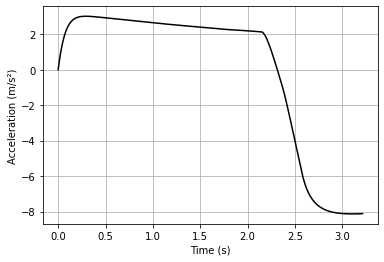

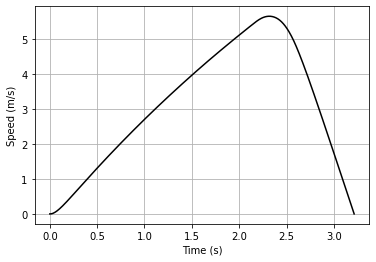

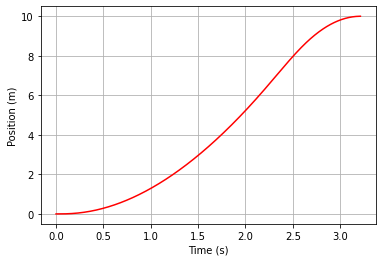

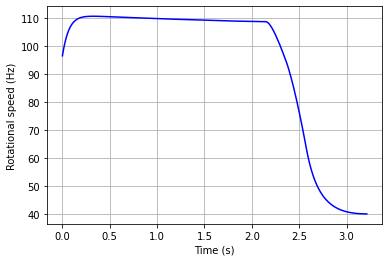

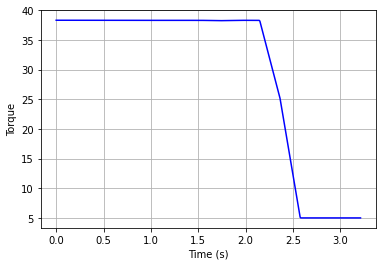

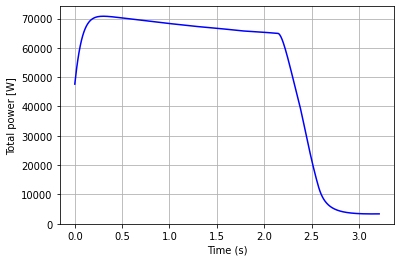

In [20]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [21]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [22]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [7]:
api.variable_viewer(OUTPUT_FILE)

In [22]:
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].